# Prediction uncertainty quantification tests with DynaMix

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append('..')

from src.model.dynamix import DynaMix
from src.model.forecaster import DynaMixForecaster
from src.metrics.metrics import geometrical_misalignment, temporal_misalignment, MASE
from src.utilities.plotting_eval import plot_3D_attractor, plot_2D_attractor, plot_TS_forecast
from src.utilities.utilities import load_hf_model

### Load Model

In [2]:
# Load the pre-trained model
model = load_hf_model("dynamix-3d-alrnn-v1.0")

# Set model to evaluation mode
model.eval()

# Initialize the forecaster
forecaster = DynaMixForecaster(model)

In [3]:
model.gating_network.sigma

Parameter containing:
tensor([0.0535, 0.0530, 0.0902], requires_grad=True)

In [4]:
model.gating_network.softmax_temp1

Parameter containing:
tensor([0.0591], requires_grad=True)

### Lorenz 63

#### Load data

In [5]:
# Forecasting Hyperparameters
CL = 2000  # Context length
T = 10000  # Prediction length
system = "lorenz63"

# Load data
data = np.load(f"test_data/{system}.npy")
context = data[:CL,:]
ground_truth = data[CL:CL+T,:]

print(f"Data shape: {data.shape}")
print(f"Context shape: {context.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

Data shape: (12000, 3)
Context shape: (2000, 3)
Ground truth shape: (10000, 3)


#### Make predictions w/ uncertainty

In [14]:
new_prediction = False   # if False, tries to load saved predictions from file

context_tensor = torch.tensor(context, dtype=torch.float32)
num_samples = 100

if new_prediction:
    # Make prediction with uncertainty using the forecasting pipeline
    with torch.no_grad():  # No gradient tracking needed for inference
        reconstruction_w_uncertainty = forecaster.forecast_w_uncertainty(
            context=context_tensor,
            horizon=T,
            num_samples=num_samples,
            standardize=True,
        )
    # Convert back to numpy for evaluation and plotting
    reconstruction_w_uncertainty_np = reconstruction_w_uncertainty.cpu().numpy()
    
    # Save prediction
    with open(f"predictions/{system}_w_uncertainty.npy", 'wb') as f:
        np.save(f, reconstruction_w_uncertainty_np)

else:
    # Load prediction
    with open(f"predictions/{system}_w_uncertainty.npy", 'rb') as f:
        reconstruction_w_uncertainty_np = np.load(f)    
    
print("Prediction_w_uncertainty shape: ", reconstruction_w_uncertainty_np.shape)

Prediction_w_uncertainty shape:  (10000, 100, 3)


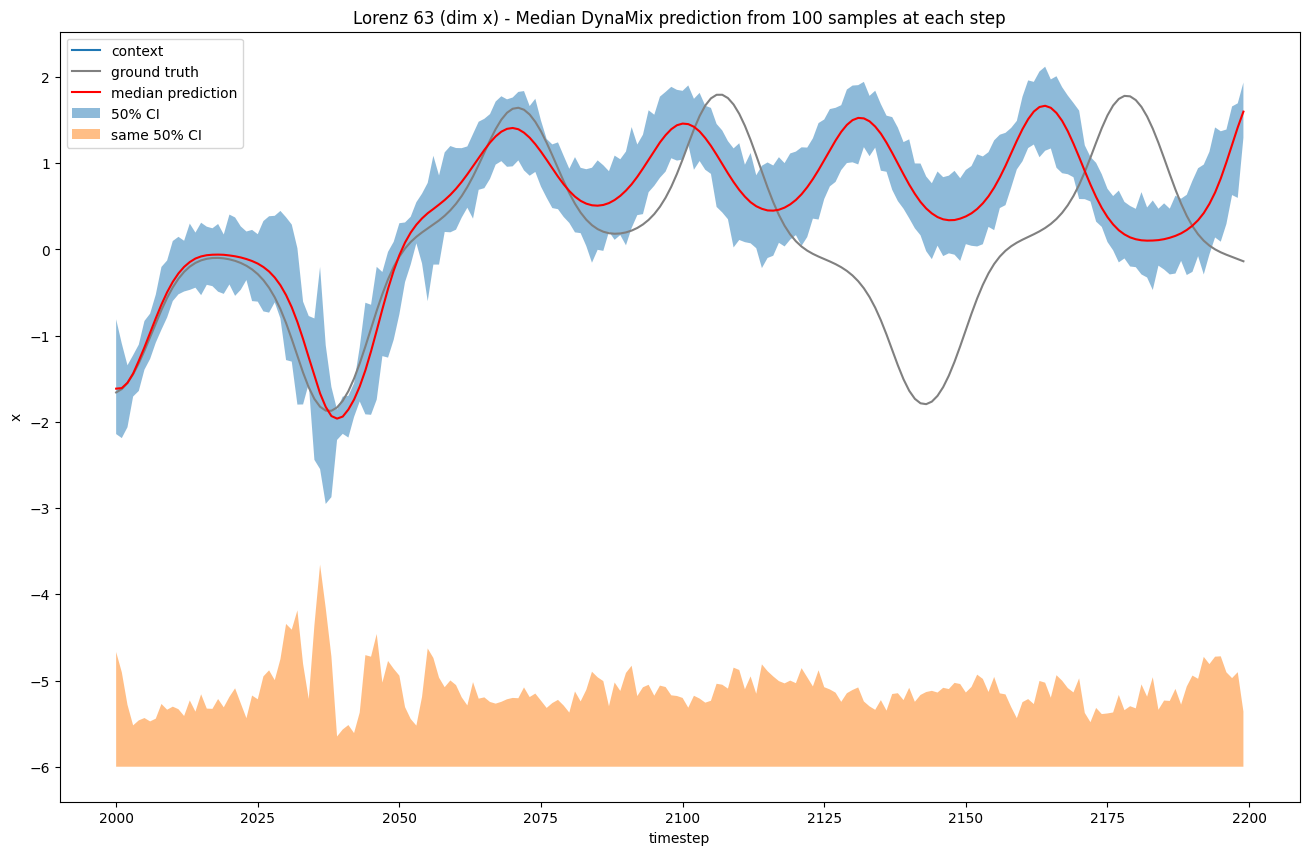

In [50]:
dim = 0  # x, y or z dimension of the Lorenz system


plt.figure(figsize=(16, 10))

# plotting some of the context
CS = CL - 0   # "context start" = at what timestep the plotting of the context starts 
t_c = np.arange(CS, CL)   # timesteps
plt.plot(t_c, context[CS:,dim], label="context")

# plotting some of the ground truth
PL = 200   # "prediction length" = how many steps after the context are plotted
t_gt = np.arange(CL, CL+PL)
plt.plot(t_gt, ground_truth[:PL,dim], c='grey', label="ground truth")

# plotting the median prediction incl. uncertainty range
exageration = 100
median = np.quantile(reconstruction_w_uncertainty_np, 0.5, axis=1)
upper  = np.quantile(reconstruction_w_uncertainty_np, 0.75, axis=1)
lower  = np.quantile(reconstruction_w_uncertainty_np, 0.25, axis=1)

plt.plot(t_gt, median[:PL, dim], c='r', label="median prediction")   # median

plt.fill_between(t_gt, 
     exageration * (upper[:PL, dim] - median[:PL, dim]) + median[:PL, dim], 
     exageration * (lower[:PL, dim] - median[:PL, dim]) + median[:PL, dim],
     alpha = 0.5, label="50% CI"
)   # 50% uncertainty range around the median

plt.fill_between(t_gt, 
     exageration * (upper[:PL, dim] - lower[:PL, dim]) - 6, 
     -6, alpha = 0.5, label="same 50% CI"
)    # same unc. range plotted below for clarity

# labeling
dimension = ["x", "y", "z"]
plt.title(f"Lorenz 63 (dim {dimension[dim]}) - Median DynaMix prediction from {num_samples} samples at each step")
plt.xlabel("timestep")
plt.ylabel(dimension[dim])
plt.legend()

plt.show()


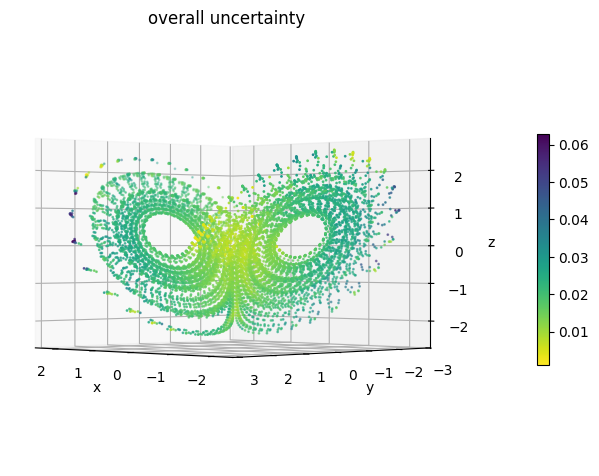

In [45]:
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=135, roll=0)
ax.set_title("overall uncertainty")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

L = 10000
#overall_uncertainty = np.sum(np.std(reconstruction_w_uncertainty_np, axis=1), axis=1)  # L1 norm
overall_uncertainty = np.sqrt(np.sum(np.std(reconstruction_w_uncertainty_np, axis=1)**2, axis=1))   # L2 norm
scatter = ax.scatter(*median[:L].T, s=1, c=overall_uncertainty[:L], cmap='viridis_r')  # uncert. via color
#scatter = ax.scatter(*median[:L].T, s=100*overall_uncertainty[:L], alpha=0.1)   # uncert. via dot size
plt.colorbar(scatter, shrink=0.5, pad=0.15)

plt.show()

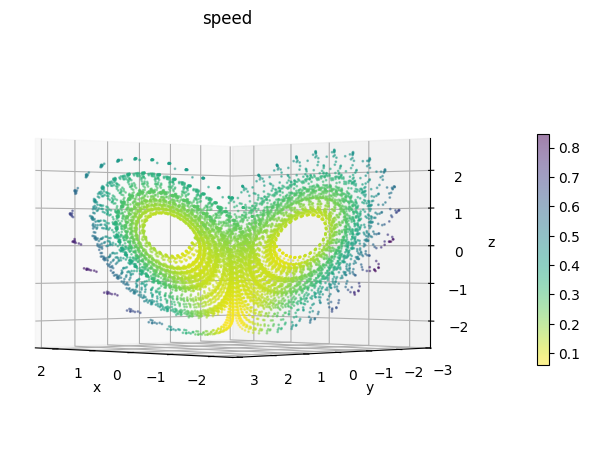

In [46]:
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=135, roll=0)
ax.set_title("speed")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

speed = np.sqrt(np.sum((median[1:]-median[:-1])**2, axis=1))
scatter = ax.scatter(*median[:-1].T, s=1, c=speed[:], cmap='viridis_r', alpha=0.5)
plt.colorbar(scatter, shrink=0.5, pad=0.15)

plt.show()

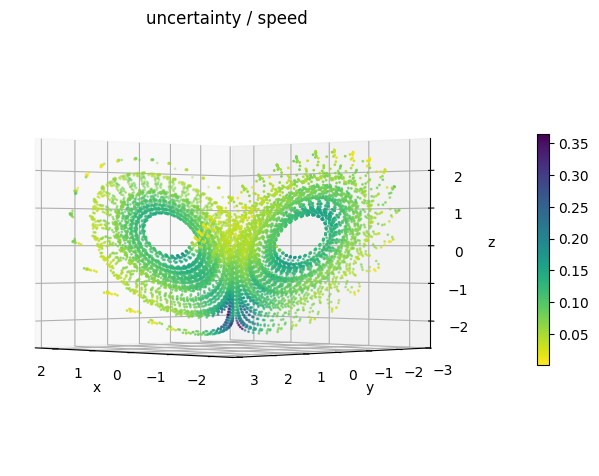

In [47]:
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=135, roll=0)
ax.set_title("uncertainty / speed")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


overall_uncertainty = np.sqrt(np.sum(np.std(reconstruction_w_uncertainty_np, axis=1)**2, axis=1))   # L2 norm
speed = np.sqrt(np.sum((median[1:]-median[:-1])**2, axis=1))
unc_over_speed = overall_uncertainty[:-1] / speed
scatter = ax.scatter(*median[:-1].T, s=1, c=unc_over_speed, cmap='viridis_r')  # uncert. via color

plt.colorbar(scatter, shrink=0.5, pad=0.15)
plt.show()